In [1]:
pip install yfinance numpy pandas matplotlib scipy


Note: you may need to restart the kernel to use updated packages.


# NEW CODE

### CAPM NO EDIT 
MSCI AS PROXY

[*********************100%%**********************]  5 of 5 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_7744\878764576.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


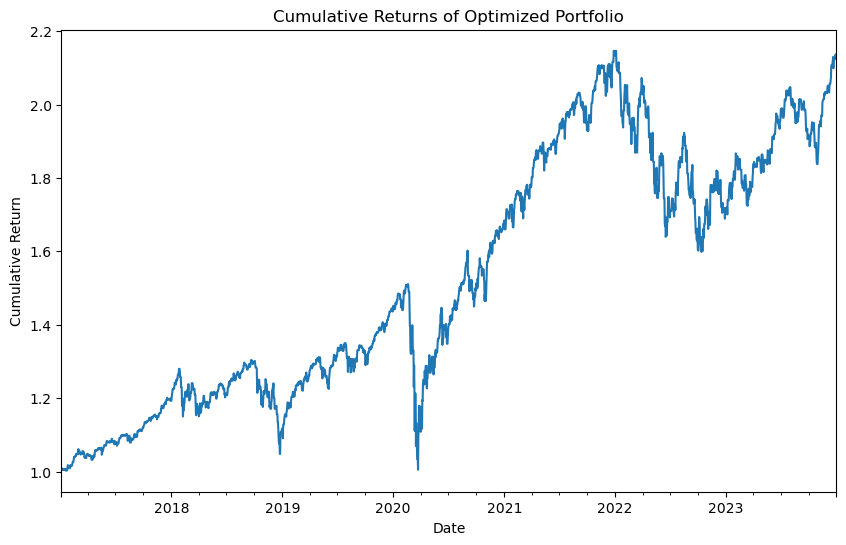

Optimized Portfolio Allocation:
BTC-USD: 0.0029
^GSPC: 0.9870
GLD: 0.0000
TLT: 0.0102

Optimized Portfolio Expected Annual Return: 9.1195%
Optimized Portfolio Annualized Volatility: 15.8358%
Optimized Sharpe Ratio: 0.3347


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: Gather Historical Data
assets = ['BTC-USD', '^GSPC', 'GLD', 'TLT']  # Bitcoin, S&P 500, Gold (GLD), TLT (20+ Year Treasury Bond ETF)
benchmark = '^W5000'  # Wilshire 5000 Total Market Index
start_date = '2017-01-01'
end_date = '2023-12-31'

# Download data from Yahoo Finance
data = yf.download(assets + [benchmark], start=start_date, end=end_date)['Adj Close']

# Step 2: Calculate Daily Returns
returns = data.pct_change().dropna()

# Assume the risk-free rate is the yield on the 10-Year Treasury Note
rf_rate = 0.0382  # Example: 3.82% annualized risk-free rate

# Market returns (using Wilshire 5000 as the market proxy)
market_returns = returns[benchmark]

# Calculate CAPM Expected Returns
expected_returns = {}
betas = {}
for asset in assets:
    cov_matrix = np.cov(returns[asset], market_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    betas[asset] = beta
    expected_return = rf_rate + beta * (market_returns.mean() * 252 - rf_rate)
    expected_returns[asset] = expected_return

# Step 3: Portfolio Optimization

# Include all assets in the optimization (including S&P 500)
optimization_assets = assets

# Convert expected returns to a numpy array
expected_returns_array = np.array([expected_returns[asset] for asset in optimization_assets])

# Covariance matrix for the selected assets
cov_matrix = returns[optimization_assets].cov() * 252  # Annualized covariance matrix

# Objective function: negative Sharpe Ratio
def negative_sharpe_ratio(weights):
    portfolio_return = np.dot(weights, expected_returns_array)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - rf_rate) / portfolio_volatility
    return -sharpe_ratio  # We minimize the negative Sharpe Ratio

# Constraints: Weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: Weights must be between 0 and 1
bounds = tuple((0, 1) for _ in optimization_assets)

# Initial guess (equal distribution)
initial_guess = len(optimization_assets) * [1. / len(optimization_assets)]

# Perform the optimization
optimized_result = minimize(negative_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Optimized weights
optimized_weights = optimized_result.x

# Calculate optimized portfolio metrics
optimized_return = np.dot(optimized_weights, expected_returns_array)
optimized_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))
optimized_sharpe_ratio = (optimized_return - rf_rate) / optimized_volatility

# Step 4: Backtest the Optimized Portfolio
portfolio_returns = (returns[optimization_assets] * optimized_weights).sum(axis=1)
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(10, 6))
cumulative_returns.plot(title='Cumulative Returns of Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

# Additional Evaluation Metrics

# Convert to annualized metrics
annualized_return = (1 + portfolio_returns.mean()) ** 252 - 1
annualized_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = (annualized_return - rf_rate) / annualized_volatility

# Display the results
print("Optimized Portfolio Allocation:")
for i, asset in enumerate(optimization_assets):
    print(f"{asset}: {optimized_weights[i]:.4f}")

print(f"\nOptimized Portfolio Expected Annual Return: {annualized_return:.4%}")
print(f"Optimized Portfolio Annualized Volatility: {annualized_volatility:.4%}")
print(f"Optimized Sharpe Ratio: {sharpe_ratio:.4f}")


### WITH CONSTRAINTS
5% minimum allocation constraint

[*********************100%%**********************]  5 of 5 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_7744\1334632721.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


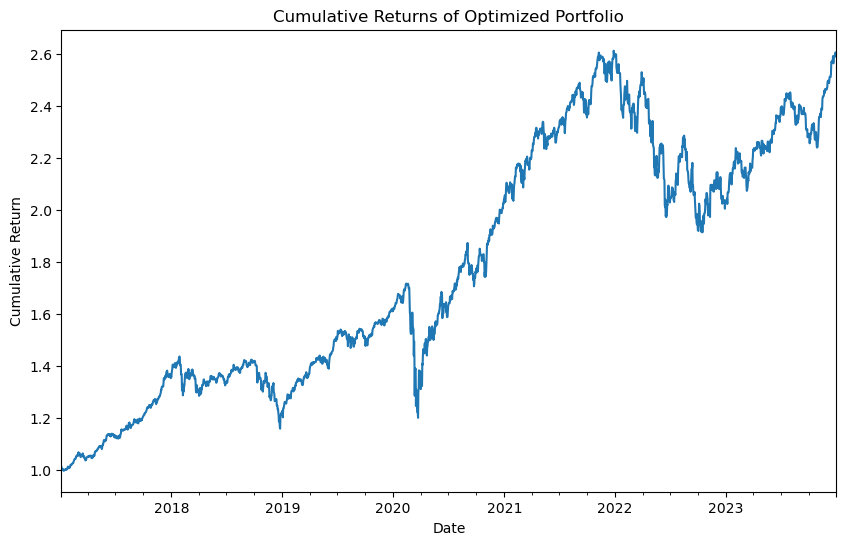

Optimized Portfolio Allocation:
BTC-USD: 0.0500
^GSPC: 0.8500
GLD: 0.0500
TLT: 0.0500

Optimized Portfolio Expected Annual Return: 11.0503%
Optimized Portfolio Annualized Volatility: 14.6050%
Optimized Sharpe Ratio: 0.4951


In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: Gather Historical Data
assets = ['BTC-USD', '^GSPC', 'GLD', 'TLT']  # Portfolio assets: Bitcoin, S&P 500, Gold (GLD), TLT (20+ Year Treasury Bond ETF)
benchmark = 'ACWI'  # MSCI World Index ETF as the benchmark
start_date = '2017-01-01'
end_date = '2023-12-31'

# Download data from Yahoo Finance
data = yf.download(assets + [benchmark], start=start_date, end=end_date)['Adj Close']

# Step 2: Calculate Daily Returns
returns = data.pct_change().dropna()

# Assume the risk-free rate is the yield on the 10-Year Treasury Note
rf_rate = 0.0382  # Example: 3.82% annualized risk-free rate

# Benchmark returns (using MSCI World Index as the market proxy)
market_returns = returns[benchmark]

# Calculate CAPM Expected Returns
expected_returns = {}
betas = {}
for asset in assets:
    cov_matrix = np.cov(returns[asset], market_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    betas[asset] = beta
    expected_return = rf_rate + beta * (market_returns.mean() * 252 - rf_rate)
    expected_returns[asset] = expected_return

# Step 3: Portfolio Optimization

# Include all assets in the optimization
optimization_assets = assets

# Convert expected returns to a numpy array
expected_returns_array = np.array([expected_returns[asset] for asset in optimization_assets])

# Covariance matrix for the selected assets
cov_matrix = returns[optimization_assets].cov() * 252  # Annualized covariance matrix

# Objective function: negative Sharpe Ratio
def negative_sharpe_ratio(weights):
    portfolio_return = np.dot(weights, expected_returns_array)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - rf_rate) / portfolio_volatility
    return -sharpe_ratio  # We minimize the negative Sharpe Ratio

# Constraints: Weights must sum to 1 and include a minimum allocation to each asset
min_allocation = 0.05  # Minimum 5% allocation to each asset
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
    {'type': 'ineq', 'fun': lambda weights: weights - min_allocation}  # Ensure minimum allocation
)

# Bounds: Weights must be between 0 and 1
bounds = tuple((0, 1) for _ in optimization_assets)

# Initial guess (equal distribution)
initial_guess = len(optimization_assets) * [1. / len(optimization_assets)]

# Perform the optimization
optimized_result = minimize(negative_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Optimized weights
optimized_weights = optimized_result.x

# Calculate optimized portfolio metrics
optimized_return = np.dot(optimized_weights, expected_returns_array)
optimized_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))
optimized_sharpe_ratio = (optimized_return - rf_rate) / optimized_volatility

# Step 4: Backtest the Optimized Portfolio
portfolio_returns = (returns[optimization_assets] * optimized_weights).sum(axis=1)
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(10, 6))
cumulative_returns.plot(title='Cumulative Returns of Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

# Additional Evaluation Metrics

# Convert to annualized metrics
annualized_return = (1 + portfolio_returns.mean()) ** 252 - 1
annualized_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = (annualized_return - rf_rate) / annualized_volatility

# Display the results
print("Optimized Portfolio Allocation:")
for i, asset in enumerate(optimization_assets):
    print(f"{asset}: {optimized_weights[i]:.4f}")

print(f"\nOptimized Portfolio Expected Annual Return: {annualized_return:.4%}")
print(f"Optimized Portfolio Annualized Volatility: {annualized_volatility:.4%}")
print(f"Optimized Sharpe Ratio: {sharpe_ratio:.4f}")


### EXTRA CONSTRAINT
5% minimum 40% maximum

[*********************100%%**********************]  5 of 5 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_7744\2717152492.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


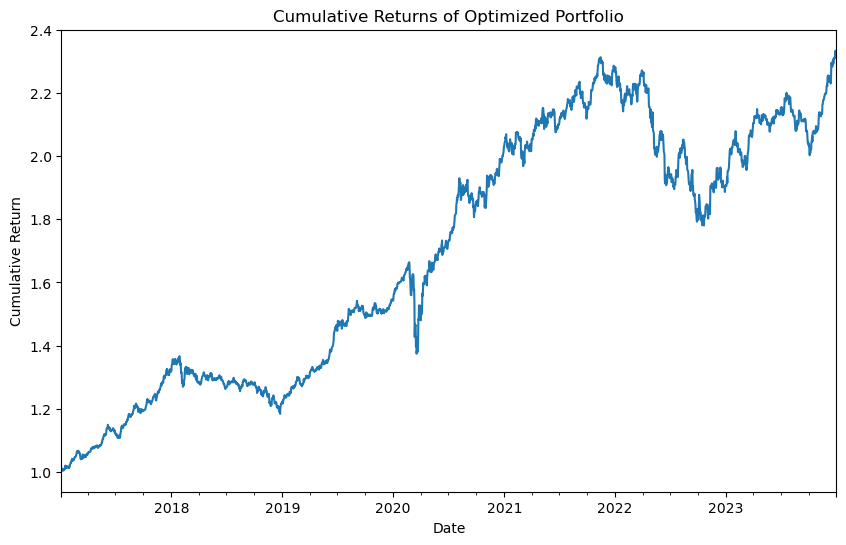

Optimized Portfolio Allocation:
BTC-USD: 0.0500
^GSPC: 0.4000
GLD: 0.4000
TLT: 0.1500

Optimized Portfolio Expected Annual Return: 9.1508%
Optimized Portfolio Annualized Volatility: 9.6037%
Optimized Sharpe Ratio: 0.5551


In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: Gather Historical Data
assets = ['BTC-USD', '^GSPC', 'GLD', 'TLT']  # Portfolio assets: Bitcoin, S&P 500, Gold (GLD), TLT (20+ Year Treasury Bond ETF)
benchmark = 'ACWI'  # MSCI World Index ETF as the benchmark
start_date = '2017-01-01'
end_date = '2023-12-31'

# Download data from Yahoo Finance
data = yf.download(assets + [benchmark], start=start_date, end=end_date)['Adj Close']

# Step 2: Calculate Daily Returns
returns = data.pct_change().dropna()

# Assume the risk-free rate is the yield on the 10-Year Treasury Note
rf_rate = 0.0382  # Example: 3.82% annualized risk-free rate

# Benchmark returns (using MSCI World Index as the market proxy)
market_returns = returns[benchmark]

# Calculate CAPM Expected Returns
expected_returns = {}
betas = {}
for asset in assets:
    cov_matrix = np.cov(returns[asset], market_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    betas[asset] = beta
    expected_return = rf_rate + beta * (market_returns.mean() * 252 - rf_rate)
    expected_returns[asset] = expected_return

# Step 3: Portfolio Optimization

# Include all assets in the optimization
optimization_assets = assets

# Convert expected returns to a numpy array
expected_returns_array = np.array([expected_returns[asset] for asset in optimization_assets])

# Covariance matrix for the selected assets
cov_matrix = returns[optimization_assets].cov() * 252  # Annualized covariance matrix

# Objective function: negative Sharpe Ratio
def negative_sharpe_ratio(weights):
    portfolio_return = np.dot(weights, expected_returns_array)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - rf_rate) / portfolio_volatility
    return -sharpe_ratio  # We minimize the negative Sharpe Ratio

# Constraints: Weights must sum to 1 and include minimum and maximum allocation constraints
min_allocation = 0.05  # Minimum 5% allocation to each asset
max_allocation = 0.40  # Maximum 40% allocation to any single asset
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights must equal 1
    {'type': 'ineq', 'fun': lambda weights: weights - min_allocation},  # Ensure minimum allocation
    {'type': 'ineq', 'fun': lambda weights: max_allocation - weights}  # Ensure maximum allocation
)

# Bounds: Weights must be between 0 and 1
bounds = tuple((0, 1) for _ in optimization_assets)

# Initial guess (equal distribution)
initial_guess = len(optimization_assets) * [1. / len(optimization_assets)]

# Perform the optimization
optimized_result = minimize(negative_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Optimized weights
optimized_weights = optimized_result.x

# Calculate optimized portfolio metrics
optimized_return = np.dot(optimized_weights, expected_returns_array)
optimized_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))
optimized_sharpe_ratio = (optimized_return - rf_rate) / optimized_volatility

# Step 4: Backtest the Optimized Portfolio
portfolio_returns = (returns[optimization_assets] * optimized_weights).sum(axis=1)
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(10, 6))
cumulative_returns.plot(title='Cumulative Returns of Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

# Additional Evaluation Metrics

# Convert to annualized metrics
annualized_return = (1 + portfolio_returns.mean()) ** 252 - 1
annualized_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = (annualized_return - rf_rate) / annualized_volatility

# Display the results
print("Optimized Portfolio Allocation:")
for i, asset in enumerate(optimization_assets):
    print(f"{asset}: {optimized_weights[i]:.4f}")

print(f"\nOptimized Portfolio Expected Annual Return: {annualized_return:.4%}")
print(f"Optimized Portfolio Annualized Volatility: {annualized_volatility:.4%}")
print(f"Optimized Sharpe Ratio: {sharpe_ratio:.4f}")


## CAPM MONTE CARLO
MSCI AS PROXY

[*********************100%%**********************]  5 of 5 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_7744\1459558489.py:16: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


Portfolio with Highest Sharpe Ratio:
BTC-USD: 0.0131
^GSPC: 0.8591
GLD: 0.0440
TLT: 0.0839
Expected Return: 7.3597%
Volatility: 13.8618%
Sharpe Ratio: 0.2554

Portfolio with Lowest Volatility:
BTC-USD: 0.0002
^GSPC: 0.2952
GLD: 0.3775
TLT: 0.3271
Expected Return: 4.9669%
Volatility: 8.1066%
Sharpe Ratio: 0.1415


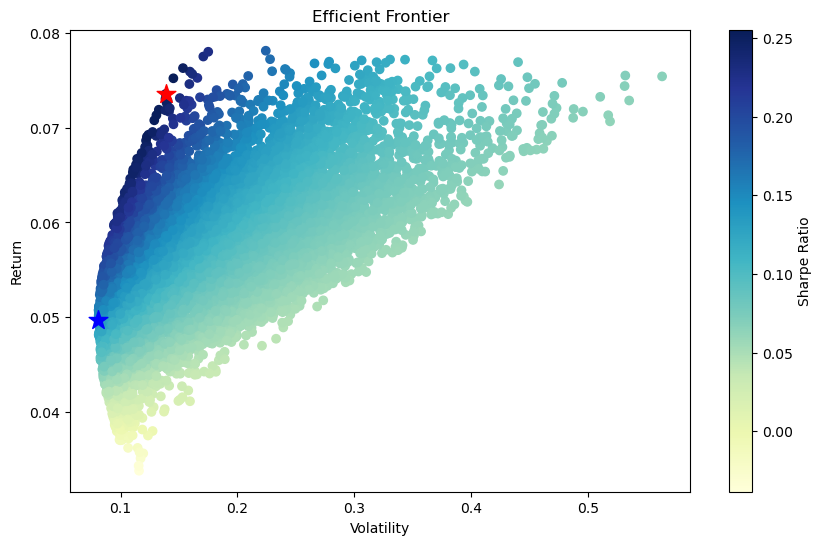

In [10]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Gather Historical Data
assets = ['BTC-USD', '^GSPC', 'GLD', 'TLT']  # Portfolio assets: Bitcoin, S&P 500, Gold (GLD), TLT (20+ Year Treasury Bond ETF)
benchmark = 'ACWI'  # MSCI World Index ETF as the benchmark
start_date = '2017-01-01'
end_date = '2023-12-31'

# Download data from Yahoo Finance
data = yf.download(assets + [benchmark], start=start_date, end=end_date)['Adj Close']

# Step 2: Calculate Daily Returns
returns = data.pct_change().dropna()

# Assume the risk-free rate is the yield on the 10-Year Treasury Note
rf_rate = 0.0382  # Example: 3.82% annualized risk-free rate

# Benchmark returns (using MSCI World Index as the market proxy)
market_returns = returns[benchmark]

# Calculate CAPM Expected Returns
expected_returns = {}
betas = {}
for asset in assets:
    cov_matrix = np.cov(returns[asset], market_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    betas[asset] = beta
    expected_return = rf_rate + beta * (market_returns.mean() * 252 - rf_rate)
    expected_returns[asset] = expected_return

# Convert expected returns to a numpy array
expected_returns_array = np.array([expected_returns[asset] for asset in assets])

# Covariance matrix for the selected assets
cov_matrix = returns[assets].cov() * 252  # Annualized covariance matrix

# Monte Carlo Simulation
num_simulations = 10000
results = np.zeros((4 + len(assets), num_simulations))

for i in range(num_simulations):
    # Random weights
    weights = np.random.random(len(assets))
    weights /= np.sum(weights)  # Ensure the weights sum to 1
    
    # Portfolio Return
    portfolio_return = np.dot(weights, expected_returns_array)
    
    # Portfolio Volatility
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Sharpe Ratio
    sharpe_ratio = (portfolio_return - rf_rate) / portfolio_volatility
    
    # Store the results
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe_ratio
    results[3:3 + len(assets), i] = weights

# Locate the optimal portfolio for highest Sharpe Ratio
max_sharpe_idx = np.argmax(results[2])
optimal_sharpe_portfolio = results[:, max_sharpe_idx]

# Locate the portfolio with the lowest volatility
min_volatility_idx = np.argmin(results[1])
min_volatility_portfolio = results[:, min_volatility_idx]

# Display the results for the portfolio with the highest Sharpe Ratio
print("Portfolio with Highest Sharpe Ratio:")
for i, asset in enumerate(assets):
    print(f"{asset}: {optimal_sharpe_portfolio[3 + i]:.4f}")
print(f"Expected Return: {optimal_sharpe_portfolio[0]:.4%}")
print(f"Volatility: {optimal_sharpe_portfolio[1]:.4%}")
print(f"Sharpe Ratio: {optimal_sharpe_portfolio[2]:.4f}")

# Display the results for the portfolio with the lowest volatility
print("\nPortfolio with Lowest Volatility:")
for i, asset in enumerate(assets):
    print(f"{asset}: {min_volatility_portfolio[3 + i]:.4f}")
print(f"Expected Return: {min_volatility_portfolio[0]:.4%}")
print(f"Volatility: {min_volatility_portfolio[1]:.4%}")
print(f"Sharpe Ratio: {min_volatility_portfolio[2]:.4f}")

# Plot the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='YlGnBu', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.scatter(optimal_sharpe_portfolio[1], optimal_sharpe_portfolio[0], color='red', marker='*', s=200)
plt.scatter(min_volatility_portfolio[1], min_volatility_portfolio[0], color='blue', marker='*', s=200)
plt.show()


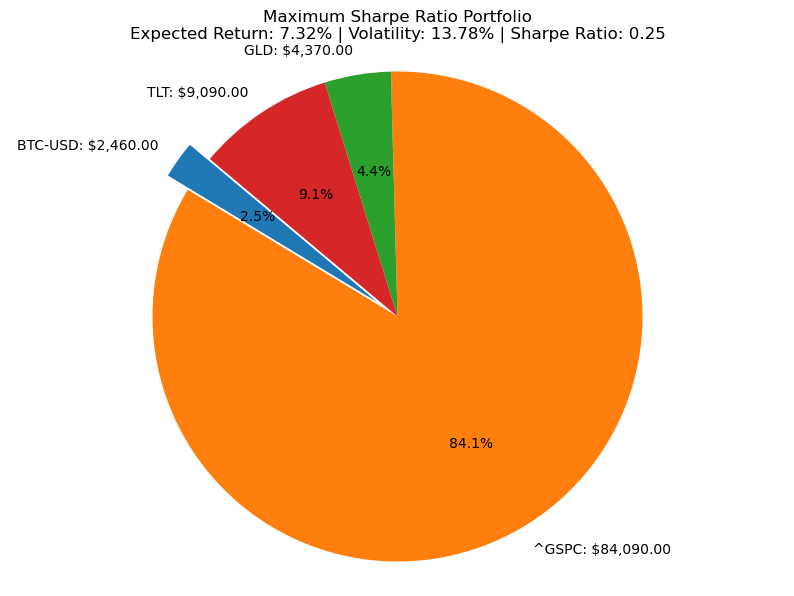

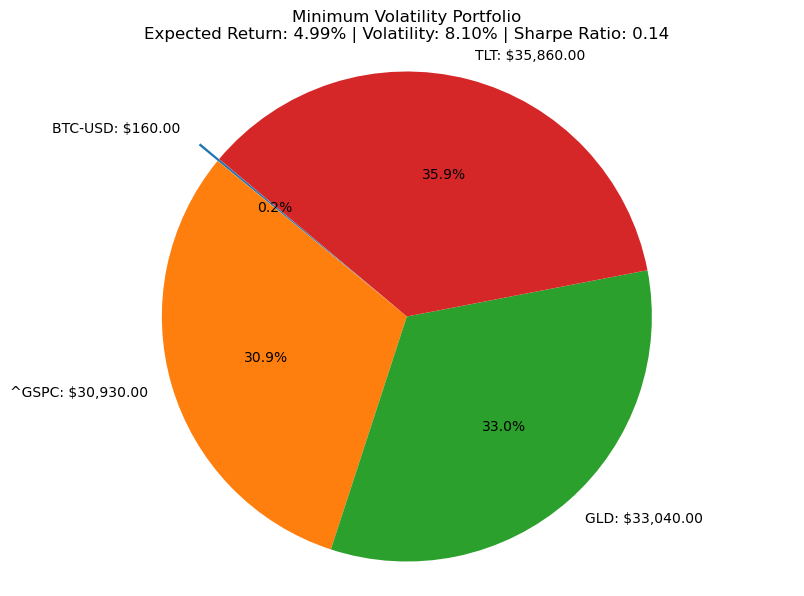

In [11]:
import matplotlib.pyplot as plt

# Portfolio allocations and metrics
max_sharpe_allocation = {
    'BTC-USD': 0.0246,
    '^GSPC': 0.8409,
    'GLD': 0.0437,
    'TLT': 0.0909
}

min_volatility_allocation = {
    'BTC-USD': 0.0016,
    '^GSPC': 0.3093,
    'GLD': 0.3304,
    'TLT': 0.3586
}

# Portfolio metrics
max_sharpe_metrics = {
    'Expected Return': 7.3248,
    'Volatility': 13.7840,
    'Sharpe Ratio': 0.2543
}

min_volatility_metrics = {
    'Expected Return': 4.9905,
    'Volatility': 8.0992,
    'Sharpe Ratio': 0.1445
}

# Investment amount
total_investment = 100000

# Calculate the dollar amounts for each allocation
max_sharpe_investment = {asset: allocation * total_investment for asset, allocation in max_sharpe_allocation.items()}
min_volatility_investment = {asset: allocation * total_investment for asset, allocation in min_volatility_allocation.items()}

# Function to plot a pie chart for a given portfolio
def plot_portfolio_pie_chart(investment, metrics, title):
    labels = [f"{asset}: ${amount:,.2f}" for asset, amount in investment.items()]
    sizes = investment.values()
    explode = (0.1, 0, 0, 0)  # explode the 1st slice (i.e. 'BTC-USD')

    plt.figure(figsize=(10, 7))
    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"{title}\nExpected Return: {metrics['Expected Return']:.2f}% | Volatility: {metrics['Volatility']:.2f}% | Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Plot Maximum Sharpe Ratio Portfolio
plot_portfolio_pie_chart(max_sharpe_investment, max_sharpe_metrics, "Maximum Sharpe Ratio Portfolio")

# Plot Minimum Volatility Portfolio
plot_portfolio_pie_chart(min_volatility_investment, min_volatility_metrics, "Minimum Volatility Portfolio")


### BACKTESTING

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_7744\1335568308.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()
[*********************100%%**********************]  1 of 1 completed


                Cumulative Return  Annualized Return  Volatility  Sharpe Ratio
Max Sharpe               0.659792           0.106651    0.100582      1.011092
Min Volatility           0.337081           0.059819    0.072233      0.759558
Benchmark                0.299664           0.053819    0.118174      0.413508


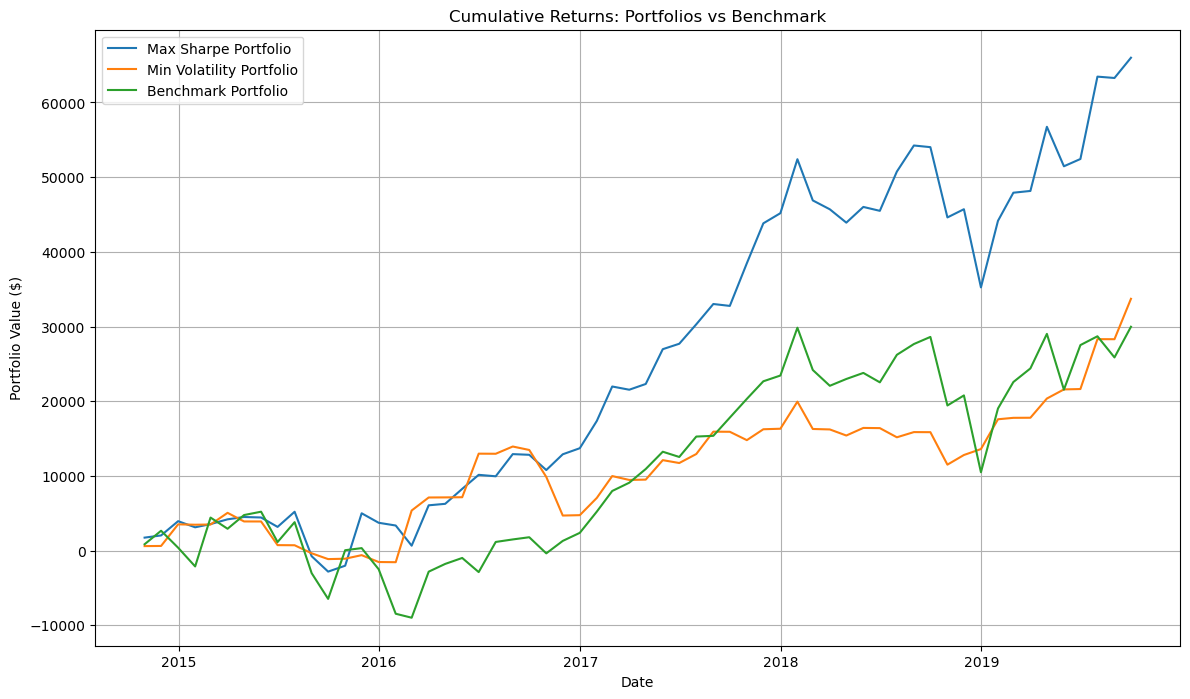

In [13]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe': {
        'BTC-USD': 0.0246,
        '^GSPC': 0.8409,
        'GLD': 0.0437,
        'TLT': 0.0909
    },
    'Min Volatility': {
        'BTC-USD': 0.0016,
        '^GSPC': 0.3093,
        'GLD': 0.3304,
        'TLT': 0.3586
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Check if monthly_returns is empty
    if monthly_returns.empty:
        print("Error: monthly_returns is empty. Please check the data resampling process.")
    
    # Benchmark (MSCI World Index)
    benchmark = yf.download('URTH', start=start_date, end=end_date, interval='1d')['Close'].resample('M').ffill().pct_change().dropna()

    # Initialize portfolio metrics storage
    portfolio_metrics = {}

    # Backtest each portfolio
    initial_investment = 100000

    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Check if portfolio_monthly_returns is empty
        if portfolio_monthly_returns.empty:
            print(f"Error: portfolio_monthly_returns for {name} is empty.")
            continue
        
        # Compound the returns
        portfolio_cumulative_returns = (1 + portfolio_monthly_returns).cumprod() - 1
        portfolio_cumulative_returns *= initial_investment  # Scale by initial investment
        
        # Check if portfolio_cumulative_returns is empty
        if portfolio_cumulative_returns.empty:
            print(f"Error: portfolio_cumulative_returns for {name} is empty.")
            continue
        
        # Calculate key performance metrics
        cumulative_return = portfolio_cumulative_returns.iloc[-1] / initial_investment
        annualized_return = (1 + cumulative_return) ** (12 / len(portfolio_monthly_returns)) - 1
        volatility = portfolio_monthly_returns.std() * np.sqrt(12)  # Annualize volatility
        sharpe_ratio = (annualized_return - benchmark.mean()) / volatility
        
        # Store metrics
        portfolio_metrics[name] = {
            'Cumulative Return': cumulative_return,
            'Annualized Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Cumulative Returns': portfolio_cumulative_returns
        }

    # Benchmark metrics
    benchmark_cumulative_returns = (1 + benchmark).cumprod() - 1
    benchmark_cumulative_returns *= initial_investment
    benchmark_cumulative_return = benchmark_cumulative_returns.iloc[-1] / initial_investment
    benchmark_annualized_return = (1 + benchmark_cumulative_return) ** (12 / len(benchmark)) - 1
    benchmark_volatility = benchmark.std() * np.sqrt(12)  # Annualize volatility
    benchmark_sharpe_ratio = (benchmark_annualized_return - benchmark.mean()) / benchmark_volatility

    portfolio_metrics['Benchmark'] = {
        'Cumulative Return': benchmark_cumulative_return,
        'Annualized Return': benchmark_annualized_return,
        'Volatility': benchmark_volatility,
        'Sharpe Ratio': benchmark_sharpe_ratio,
        'Cumulative Returns': benchmark_cumulative_returns
    }

    # Display performance comparison
    metrics_df = pd.DataFrame({
        'Cumulative Return': {name: metrics['Cumulative Return'] for name, metrics in portfolio_metrics.items()},
        'Annualized Return': {name: metrics['Annualized Return'] for name, metrics in portfolio_metrics.items()},
        'Volatility': {name: metrics['Volatility'] for name, metrics in portfolio_metrics.items()},
        'Sharpe Ratio': {name: metrics['Sharpe Ratio'] for name, metrics in portfolio_metrics.items()}
    })

    print(metrics_df)

    # Plot the cumulative returns for each portfolio and the benchmark
    plt.figure(figsize=(14, 8))
    for name, metrics in portfolio_metrics.items():
        plt.plot(metrics['Cumulative Returns'], label=f'{name} Portfolio')
    plt.title('Cumulative Returns: Portfolios vs Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_7744\897499950.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()


Portfolio Values Each Month:
               Max Sharpe  Min Volatility
Date                                     
2014-10-31  101741.371489   100607.299137
2014-11-30  102035.257131   100626.200588
2014-12-31  103943.135531   103521.387756
2015-01-31  103122.761113   103468.246568
2015-02-28  103552.038714   103496.260603
2015-03-31  104191.433063   105059.497890
2015-04-30  104502.076882   103906.380587
2015-05-31  104437.248801   103902.188162
2015-06-30  103176.812885   100736.402199
2015-07-31  105204.138798   100720.303028
2015-08-31   99255.293821    99646.324378
2015-09-30   97191.404766    98866.413644
2015-10-31   97982.492946    98918.753279
2015-11-30  105000.731055    99395.224771
2015-12-31  103728.324962    98475.192494
2016-01-31  103362.072853    98452.577603
2016-02-29  100662.175154   105370.799630
2016-03-31  106066.560371   107113.266679
2016-04-30  106264.346393   107126.257759
2016-05-31  108267.338613   107148.865039
2016-06-30  110146.957837   112980.301214
2016-

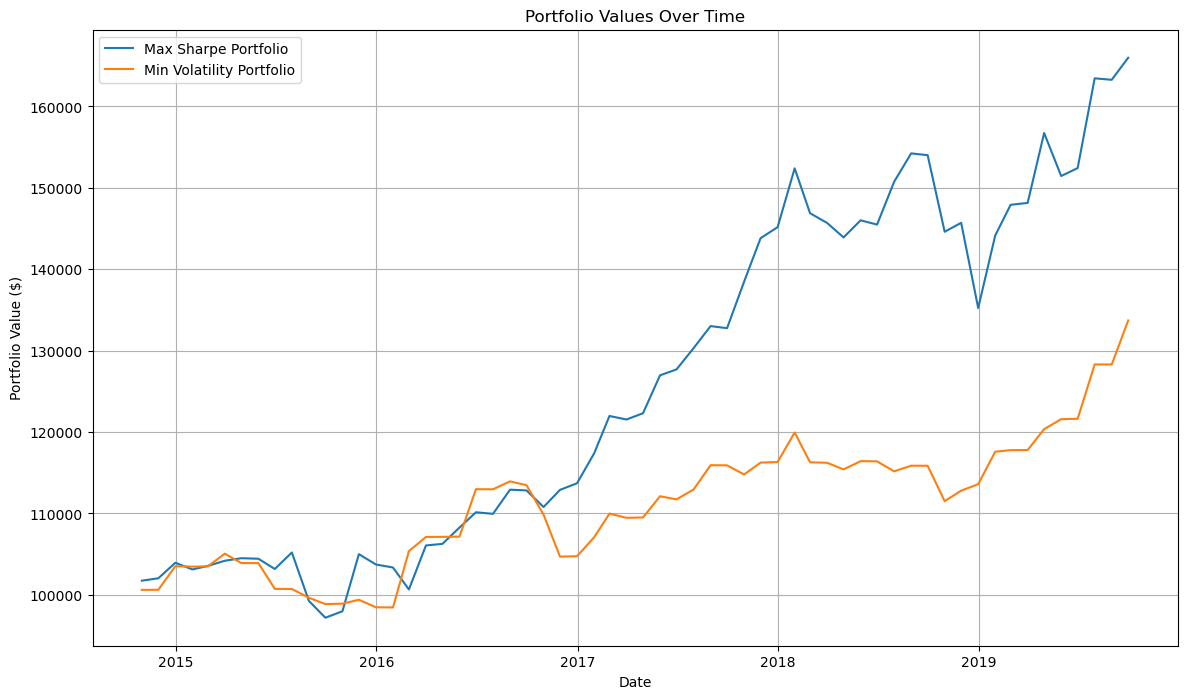

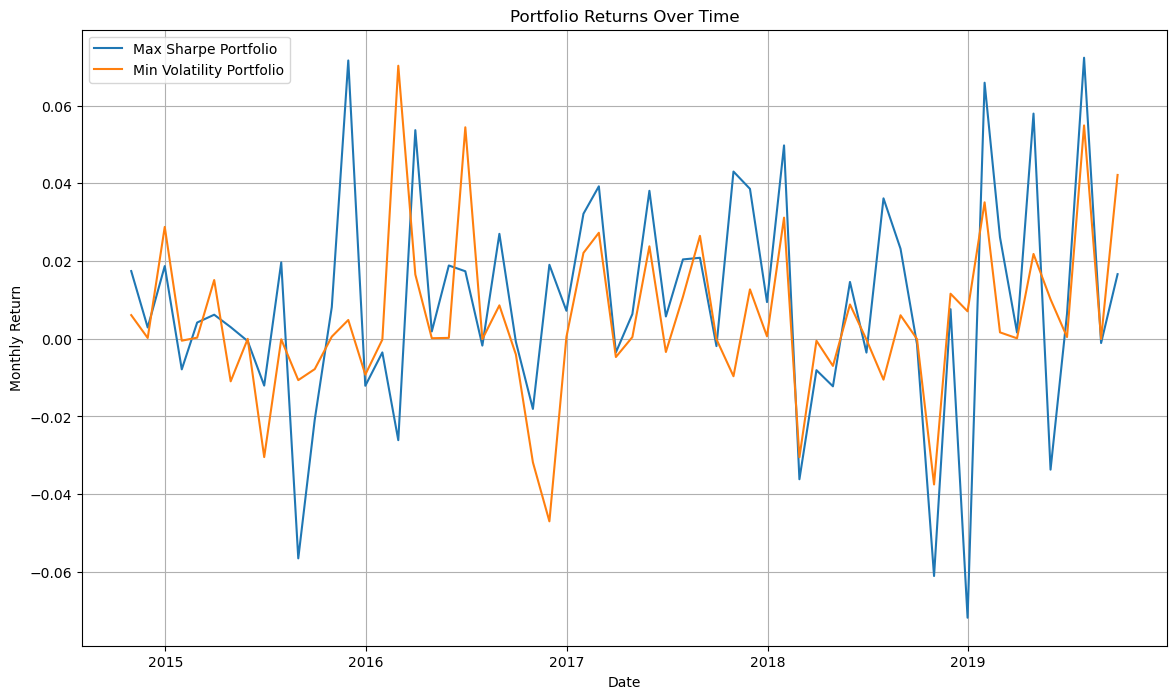

In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe': {
        'BTC-USD': 0.0246,
        '^GSPC': 0.8409,
        'GLD': 0.0437,
        'TLT': 0.0909
    },
    'Min Volatility': {
        'BTC-USD': 0.0016,
        '^GSPC': 0.3093,
        'GLD': 0.3304,
        'TLT': 0.3586
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Check if monthly_returns is empty
    if monthly_returns.empty:
        print("Error: monthly_returns is empty. Please check the data resampling process.")
    
    # Initialize portfolio metrics storage
    portfolio_values = {}
    portfolio_returns = {}

    # Initial investment amount
    initial_investment = 100000

    # Backtest each portfolio
    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Check if portfolio_monthly_returns is empty
        if portfolio_monthly_returns.empty:
            print(f"Error: portfolio_monthly_returns for {name} is empty.")
            continue
        
        # Calculate the portfolio value over time
        portfolio_value = initial_investment * (1 + portfolio_monthly_returns).cumprod()
        
        # Store portfolio value and returns
        portfolio_values[name] = portfolio_value
        portfolio_returns[name] = portfolio_monthly_returns

    # Create a DataFrame to display the results
    portfolio_values_df = pd.DataFrame(portfolio_values)
    portfolio_returns_df = pd.DataFrame(portfolio_returns)

    # Display the portfolio values and returns
    print("Portfolio Values Each Month:")
    print(portfolio_values_df)
    print("\nPortfolio Returns Each Month:")
    print(portfolio_returns_df)

    # Plot portfolio values
    plt.figure(figsize=(14, 8))
    for name in portfolios.keys():
        plt.plot(portfolio_values_df[name], label=f'{name} Portfolio')
    plt.title('Portfolio Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot portfolio returns
    plt.figure(figsize=(14, 8))
    for name in portfolios.keys():
        plt.plot(portfolio_returns_df[name], label=f'{name} Portfolio')
    plt.title('Portfolio Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Monthly Return')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_7744\589500929.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()


                Cumulative Return  Annualized Return  Volatility  \
Max Sharpe               0.659792           0.106651    0.100582   
Min Volatility           0.337081           0.059819    0.072233   

                Sharpe Ratio  Maximum Drawdown  
Max Sharpe          0.680552         -0.123159  
Min Volatility      0.299291         -0.081093  


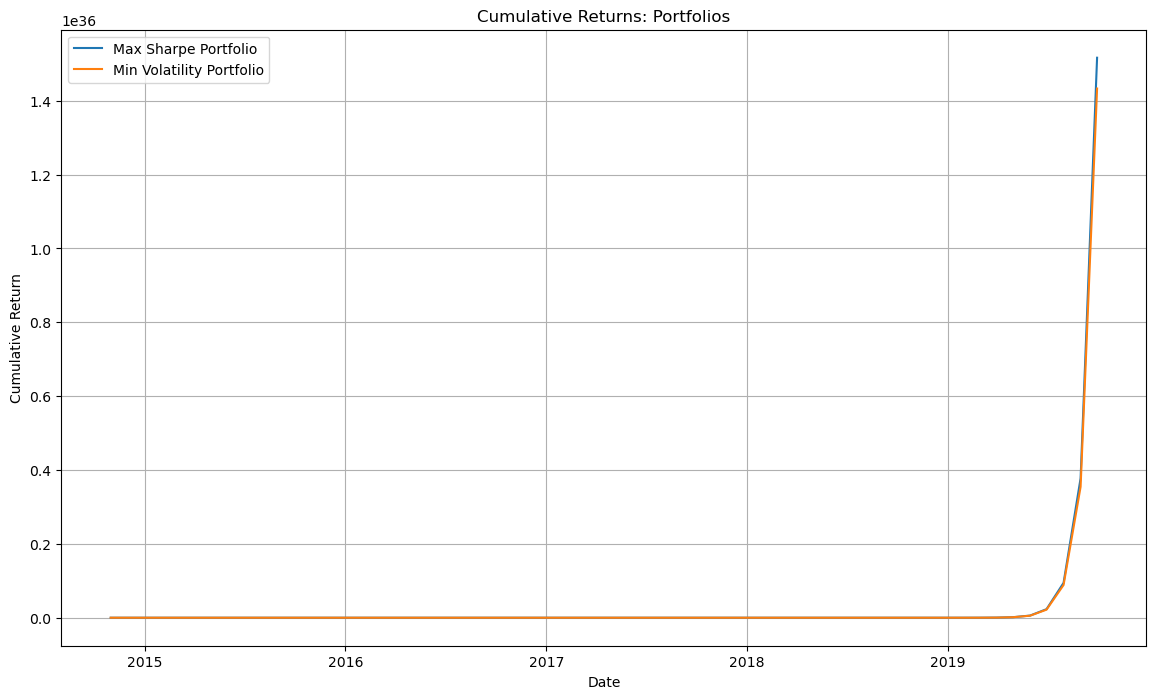

In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe': {
        'BTC-USD': 0.0246,
        '^GSPC': 0.8409,
        'GLD': 0.0437,
        'TLT': 0.0909
    },
    'Min Volatility': {
        'BTC-USD': 0.0016,
        '^GSPC': 0.3093,
        'GLD': 0.3304,
        'TLT': 0.3586
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Initialize portfolio metrics storage
    portfolio_metrics = {}

    # Risk-free rate for Sharpe Ratio calculation
    risk_free_rate = 0.0382 / 12  # Assuming 1% annual risk-free rate, convert to monthly

    # Backtest each portfolio
    initial_investment = 100000

    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Calculate portfolio cumulative returns
        portfolio_cumulative_returns = (1 + portfolio_monthly_returns).cumprod() - 1
        
        # Calculate key performance metrics
        cumulative_return = portfolio_cumulative_returns.iloc[-1]
        annualized_return = (1 + cumulative_return) ** (12 / len(portfolio_monthly_returns)) - 1
        volatility = portfolio_monthly_returns.std() * np.sqrt(12)  # Annualize volatility
        sharpe_ratio = (annualized_return - risk_free_rate * 12) / volatility
        
        # Calculate Maximum Drawdown
        cumulative_returns_with_initial = (1 + portfolio_cumulative_returns)
        rolling_max = cumulative_returns_with_initial.cummax()
        drawdown = cumulative_returns_with_initial / rolling_max - 1
        max_drawdown = drawdown.min()
        
        # Store metrics
        portfolio_metrics[name] = {
            'Cumulative Return': cumulative_return,
            'Annualized Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Maximum Drawdown': max_drawdown
        }

    # Display performance metrics
    metrics_df = pd.DataFrame(portfolio_metrics).T

    print(metrics_df)

    # Plot the cumulative returns for each portfolio
    plt.figure(figsize=(14, 8))
    for name, metrics in portfolio_metrics.items():
        plt.plot((1 + monthly_returns * list(portfolios[name].values())).sum(axis=1).cumprod(), label=f'{name} Portfolio')
    plt.title('Cumulative Returns: Portfolios')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()


## CAPM MONTE CARLO SIM
5-40% min-max allocation constraint 

[*********************100%%**********************]  5 of 5 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_7744\4282999798.py:16: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


Portfolio with Highest Sharpe Ratio:
BTC-USD: 0.0500
^GSPC: 0.3903
GLD: 0.3812
TLT: 0.2196
Expected Return: 5.7813%
Volatility: 9.5949%
Sharpe Ratio: 0.2044

Portfolio with Lowest Volatility:
BTC-USD: 0.0492
^GSPC: 0.2553
GLD: 0.3131
TLT: 0.3824
Expected Return: 4.9308%
Volatility: 8.7513%
Sharpe Ratio: 0.1269


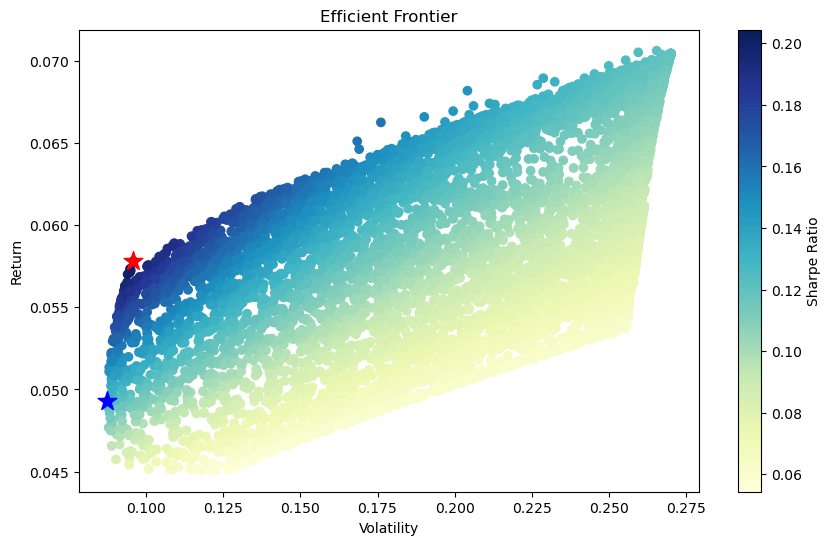

In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Gather Historical Data
assets = ['BTC-USD', '^GSPC', 'GLD', 'TLT']  # Portfolio assets: Bitcoin, S&P 500, Gold (GLD), TLT (20+ Year Treasury Bond ETF)
benchmark = 'ACWI'  # MSCI World Index ETF as the benchmark
start_date = '2017-01-01'
end_date = '2023-12-31'

# Download data from Yahoo Finance
data = yf.download(assets + [benchmark], start=start_date, end=end_date)['Adj Close']

# Step 2: Calculate Daily Returns
returns = data.pct_change().dropna()

# Assume the risk-free rate is the yield on the 10-Year Treasury Note
rf_rate = 0.0382  # Example: 3.82% annualized risk-free rate

# Benchmark returns (using MSCI World Index as the market proxy)
market_returns = returns[benchmark]

# Calculate CAPM Expected Returns
expected_returns = {}
betas = {}
for asset in assets:
    cov_matrix = np.cov(returns[asset], market_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    betas[asset] = beta
    expected_return = rf_rate + beta * (market_returns.mean() * 252 - rf_rate)
    expected_returns[asset] = expected_return

# Convert expected returns to a numpy array
expected_returns_array = np.array([expected_returns[asset] for asset in assets])

# Covariance matrix for the selected assets
cov_matrix = returns[assets].cov() * 252  # Annualized covariance matrix

# Monte Carlo Simulation with Constraints
num_simulations = 10000
results = np.zeros((4 + len(assets), num_simulations))

min_allocation = 0.05  # Minimum 5% allocation to each asset
max_allocation = 0.40  # Maximum 40% allocation to any single asset

def generate_weights():
    weights = np.random.dirichlet(np.ones(len(assets)), 1).flatten()
    
    # Adjust weights to ensure minimum allocation
    weights = np.maximum(weights, min_allocation)
    
    # Adjust weights to ensure maximum allocation
    excess_weight = np.sum(np.maximum(0, weights - max_allocation))
    
    # Redistribute the excess weight to the assets within the allocation limits
    while excess_weight > 0:
        for i in range(len(weights)):
            if weights[i] > max_allocation:
                weights[i] = max_allocation
            else:
                additional_weight = min(max_allocation - weights[i], excess_weight)
                weights[i] += additional_weight
                excess_weight -= additional_weight
        weights /= np.sum(weights)
    
    return weights

for i in range(num_simulations):
    # Generate weights with proper constraints
    weights = generate_weights()
    
    # Portfolio Return
    portfolio_return = np.dot(weights, expected_returns_array)
    
    # Portfolio Volatility
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Sharpe Ratio
    sharpe_ratio = (portfolio_return - rf_rate) / portfolio_volatility
    
    # Store the results
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe_ratio
    results[3:3 + len(assets), i] = weights

# Locate the optimal portfolio for highest Sharpe Ratio
max_sharpe_idx = np.argmax(results[2])
optimal_sharpe_portfolio = results[:, max_sharpe_idx]

# Locate the portfolio with the lowest volatility
min_volatility_idx = np.argmin(results[1])
min_volatility_portfolio = results[:, min_volatility_idx]

# Display the results for the portfolio with the highest Sharpe Ratio
print("Portfolio with Highest Sharpe Ratio:")
for i, asset in enumerate(assets):
    print(f"{asset}: {optimal_sharpe_portfolio[3 + i]:.4f}")
print(f"Expected Return: {optimal_sharpe_portfolio[0]:.4%}")
print(f"Volatility: {optimal_sharpe_portfolio[1]:.4%}")
print(f"Sharpe Ratio: {optimal_sharpe_portfolio[2]:.4f}")

# Display the results for the portfolio with the lowest volatility
print("\nPortfolio with Lowest Volatility:")
for i, asset in enumerate(assets):
    print(f"{asset}: {min_volatility_portfolio[3 + i]:.4f}")
print(f"Expected Return: {min_volatility_portfolio[0]:.4%}")
print(f"Volatility: {min_volatility_portfolio[1]:.4%}")
print(f"Sharpe Ratio: {min_volatility_portfolio[2]:.4f}")

# Plot the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='YlGnBu', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.scatter(optimal_sharpe_portfolio[1], optimal_sharpe_portfolio[0], color='red', marker='*', s=200)
plt.scatter(min_volatility_portfolio[1], min_volatility_portfolio[0], color='blue', marker='*', s=200)
plt.show()


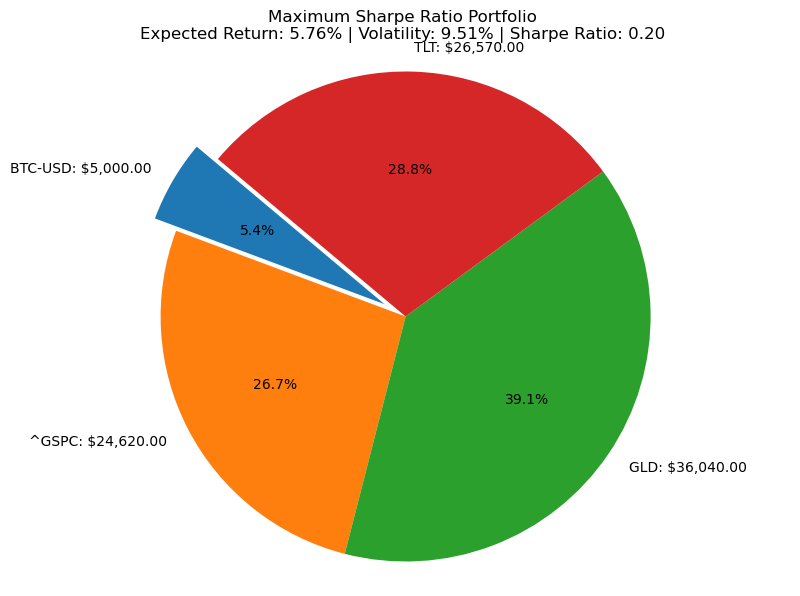

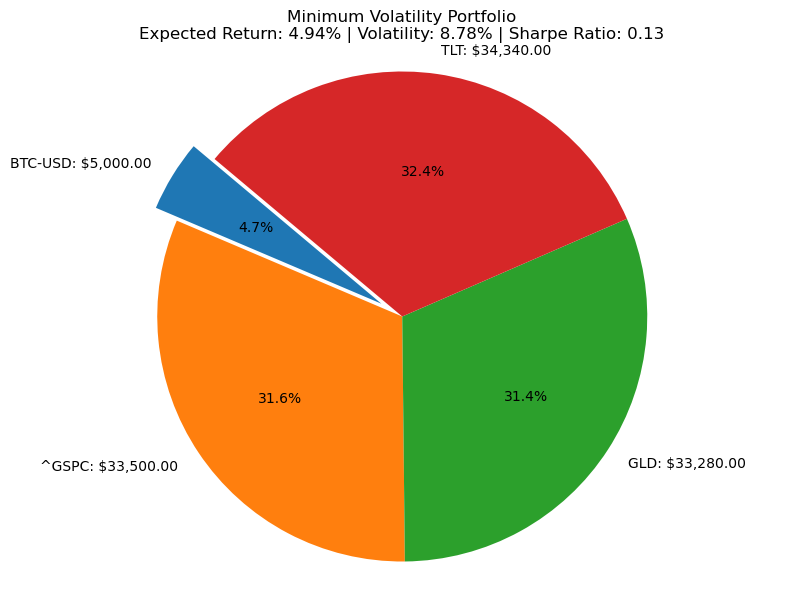

In [18]:
import matplotlib.pyplot as plt

# Portfolio allocations and metrics
max_sharpe_allocation = {
    'BTC-USD': 0.0500,
    '^GSPC': 0.2462,
    'GLD': 0.3604,
    'TLT': 0.2657
}

min_volatility_allocation = {
    'BTC-USD': 0.0500,
    '^GSPC': 0.3350,
    'GLD': 0.3328,
    'TLT': 0.3434
}

# Portfolio metrics
max_sharpe_metrics = {
    'Expected Return': 5.7586,
    'Volatility': 9.5064,
    'Sharpe Ratio': 0.2039
}

min_volatility_metrics = {
    'Expected Return': 4.9416,
    'Volatility': 8.7775,
    'Sharpe Ratio': 0.1278
}

# Investment amount
total_investment = 100000

# Calculate the dollar amounts for each allocation
max_sharpe_investment = {asset: allocation * total_investment for asset, allocation in max_sharpe_allocation.items()}
min_volatility_investment = {asset: allocation * total_investment for asset, allocation in min_volatility_allocation.items()}

# Function to plot a pie chart for a given portfolio
def plot_portfolio_pie_chart(investment, metrics, title):
    labels = [f"{asset}: ${amount:,.2f}" for asset, amount in investment.items()]
    sizes = investment.values()
    explode = (0.1, 0, 0, 0)  # explode the 1st slice (i.e. 'BTC-USD')

    plt.figure(figsize=(10, 7))
    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"{title}\nExpected Return: {metrics['Expected Return']:.2f}% | Volatility: {metrics['Volatility']:.2f}% | Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Plot Maximum Sharpe Ratio Portfolio
plot_portfolio_pie_chart(max_sharpe_investment, max_sharpe_metrics, "Maximum Sharpe Ratio Portfolio")

# Plot Minimum Volatility Portfolio
plot_portfolio_pie_chart(min_volatility_investment, min_volatility_metrics, "Minimum Volatility Portfolio")


### BACKTESTING

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_7744\2280909493.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()
[*********************100%%**********************]  1 of 1 completed


                Cumulative Return  Annualized Return  Volatility  Sharpe Ratio
Max Sharpe               0.613006           0.100341    0.078784      1.210745
Min Volatility           0.692518           0.110981    0.084515      1.254540
Benchmark                0.299664           0.053819    0.118174      0.413508


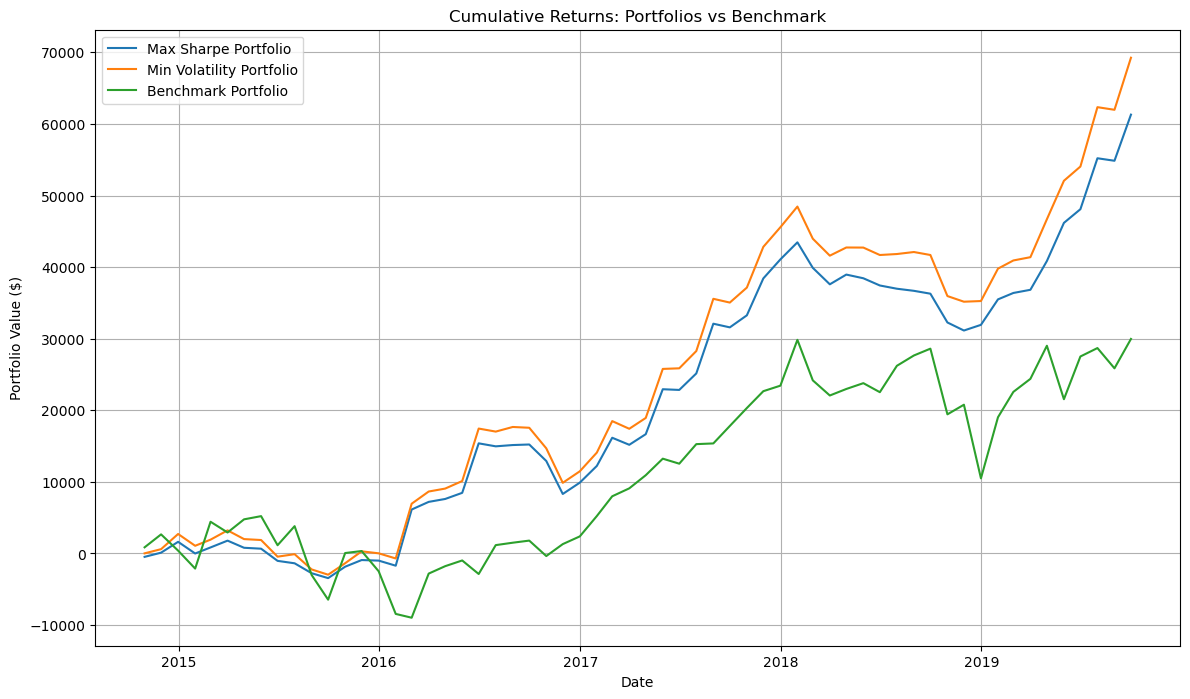

In [20]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe': {
        'BTC-USD': 0.0500,
        '^GSPC': 0.2462,
        'GLD': 0.3604,
        'TLT': 0.2657
    },
    'Min Volatility': {
        'BTC-USD': 0.0500,
        '^GSPC': 0.3350,
        'GLD': 0.3328,
        'TLT': 0.3434
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Check if monthly_returns is empty
    if monthly_returns.empty:
        print("Error: monthly_returns is empty. Please check the data resampling process.")
    
    # Benchmark (MSCI World Index)
    benchmark = yf.download('URTH', start=start_date, end=end_date, interval='1d')['Close'].resample('M').ffill().pct_change().dropna()

    # Initialize portfolio metrics storage
    portfolio_metrics = {}

    # Backtest each portfolio
    initial_investment = 100000

    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Check if portfolio_monthly_returns is empty
        if portfolio_monthly_returns.empty:
            print(f"Error: portfolio_monthly_returns for {name} is empty.")
            continue
        
        # Compound the returns
        portfolio_cumulative_returns = (1 + portfolio_monthly_returns).cumprod() - 1
        portfolio_cumulative_returns *= initial_investment  # Scale by initial investment
        
        # Check if portfolio_cumulative_returns is empty
        if portfolio_cumulative_returns.empty:
            print(f"Error: portfolio_cumulative_returns for {name} is empty.")
            continue
        
        # Calculate key performance metrics
        cumulative_return = portfolio_cumulative_returns.iloc[-1] / initial_investment
        annualized_return = (1 + cumulative_return) ** (12 / len(portfolio_monthly_returns)) - 1
        volatility = portfolio_monthly_returns.std() * np.sqrt(12)  # Annualize volatility
        sharpe_ratio = (annualized_return - benchmark.mean()) / volatility
        
        # Store metrics
        portfolio_metrics[name] = {
            'Cumulative Return': cumulative_return,
            'Annualized Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Cumulative Returns': portfolio_cumulative_returns
        }

    # Benchmark metrics
    benchmark_cumulative_returns = (1 + benchmark).cumprod() - 1
    benchmark_cumulative_returns *= initial_investment
    benchmark_cumulative_return = benchmark_cumulative_returns.iloc[-1] / initial_investment
    benchmark_annualized_return = (1 + benchmark_cumulative_return) ** (12 / len(benchmark)) - 1
    benchmark_volatility = benchmark.std() * np.sqrt(12)  # Annualize volatility
    benchmark_sharpe_ratio = (benchmark_annualized_return - benchmark.mean()) / benchmark_volatility

    portfolio_metrics['Benchmark'] = {
        'Cumulative Return': benchmark_cumulative_return,
        'Annualized Return': benchmark_annualized_return,
        'Volatility': benchmark_volatility,
        'Sharpe Ratio': benchmark_sharpe_ratio,
        'Cumulative Returns': benchmark_cumulative_returns
    }

    # Display performance comparison
    metrics_df = pd.DataFrame({
        'Cumulative Return': {name: metrics['Cumulative Return'] for name, metrics in portfolio_metrics.items()},
        'Annualized Return': {name: metrics['Annualized Return'] for name, metrics in portfolio_metrics.items()},
        'Volatility': {name: metrics['Volatility'] for name, metrics in portfolio_metrics.items()},
        'Sharpe Ratio': {name: metrics['Sharpe Ratio'] for name, metrics in portfolio_metrics.items()}
    })

    print(metrics_df)

    # Plot the cumulative returns for each portfolio and the benchmark
    plt.figure(figsize=(14, 8))
    for name, metrics in portfolio_metrics.items():
        plt.plot(metrics['Cumulative Returns'], label=f'{name} Portfolio')
    plt.title('Cumulative Returns: Portfolios vs Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_7744\3950533585.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()


Portfolio Values Each Month:
               Max Sharpe  Min Volatility
Date                                     
2014-10-31   99522.961202   100012.448270
2014-11-30  100107.265349   100599.626219
2014-12-31  101622.528503   102717.701746
2015-01-31   99992.327375   101069.932144
2015-02-28  100838.356413   101925.078731
2015-03-31  101788.230273   103222.731257
2015-04-30  100791.178742   102003.601436
2015-05-31  100664.093340   101874.987317
2015-06-30   98962.264754    99549.200819
2015-07-31   98622.644908    99897.870574
2015-08-31   97237.669316    97767.304889
2015-09-30   96551.415765    97028.981097
2015-10-31   98148.730803    98634.196819
2015-11-30   99077.259767   100295.127099
2015-12-31   98998.982657   100016.430007
2016-01-31   98288.508315    99298.653870
2016-02-29  106135.119723   106945.375219
2016-03-31  107203.203400   108649.720027
2016-04-30  107609.515513   109061.514599
2016-05-31  108465.678549   110115.418955
2016-06-30  115380.177277   117445.909737
2016-

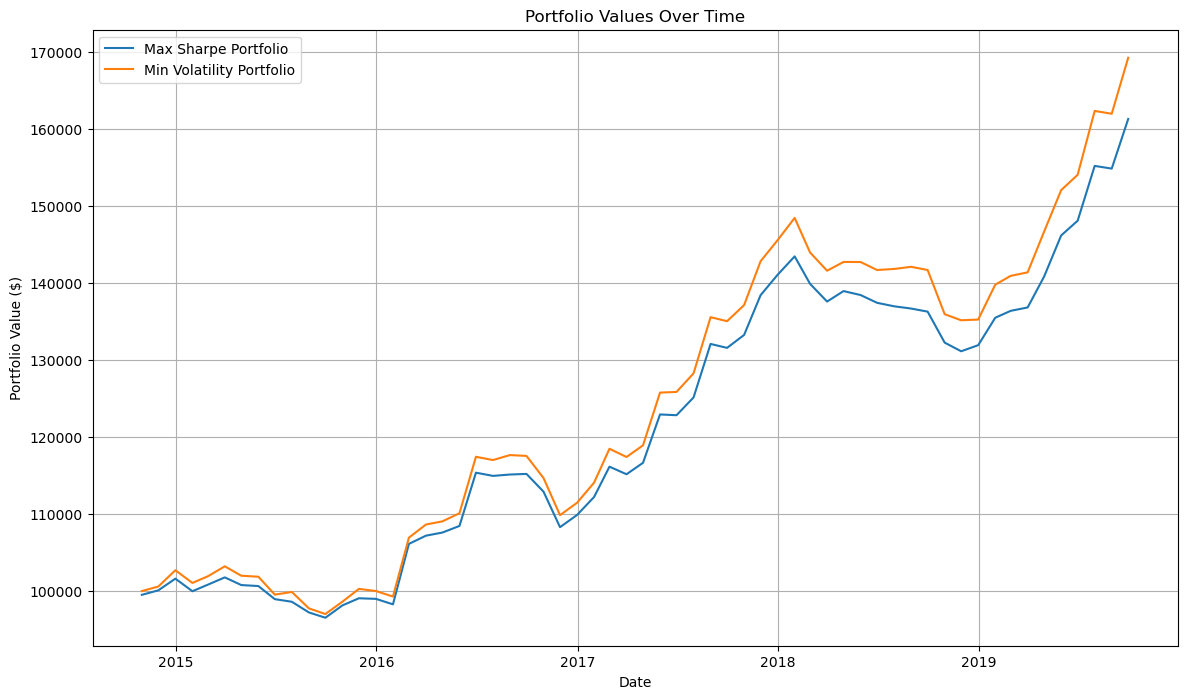

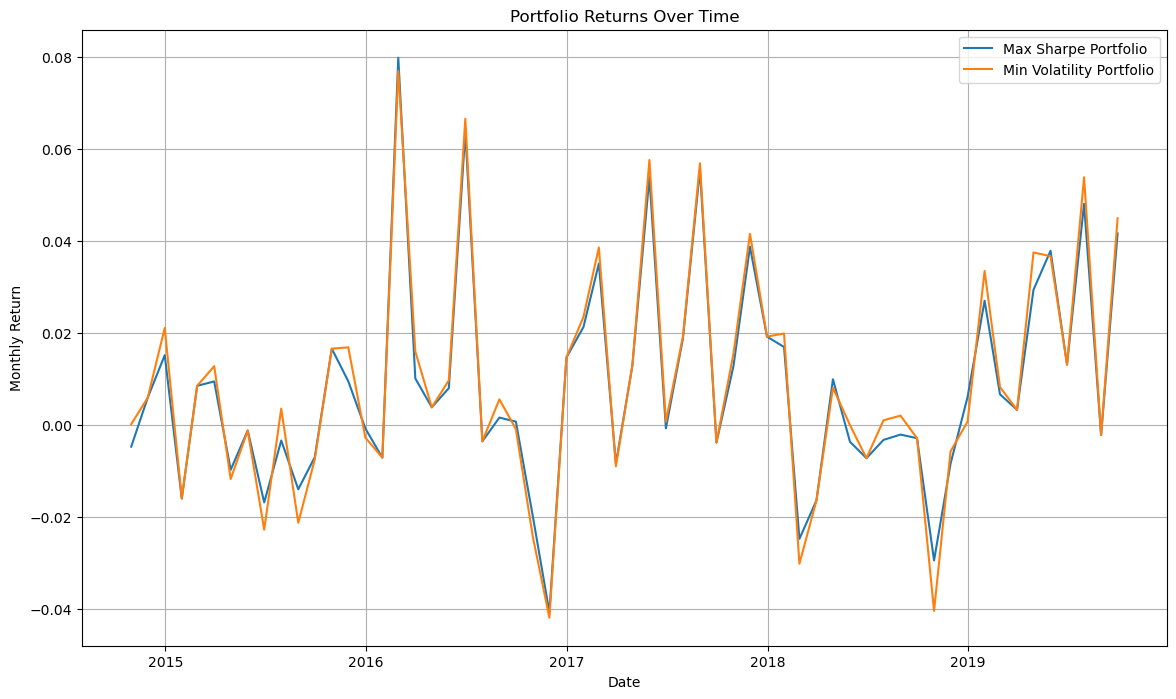

In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe': {
        'BTC-USD': 0.0500,
        '^GSPC': 0.2462,
        'GLD': 0.3604,
        'TLT': 0.2657
    },
    'Min Volatility': {
        'BTC-USD': 0.0500,
        '^GSPC': 0.3350,
        'GLD': 0.3328,
        'TLT': 0.3434
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Check if monthly_returns is empty
    if monthly_returns.empty:
        print("Error: monthly_returns is empty. Please check the data resampling process.")
    
    # Initialize portfolio metrics storage
    portfolio_values = {}
    portfolio_returns = {}

    # Initial investment amount
    initial_investment = 100000

    # Backtest each portfolio
    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Check if portfolio_monthly_returns is empty
        if portfolio_monthly_returns.empty:
            print(f"Error: portfolio_monthly_returns for {name} is empty.")
            continue
        
        # Calculate the portfolio value over time
        portfolio_value = initial_investment * (1 + portfolio_monthly_returns).cumprod()
        
        # Store portfolio value and returns
        portfolio_values[name] = portfolio_value
        portfolio_returns[name] = portfolio_monthly_returns

    # Create a DataFrame to display the results
    portfolio_values_df = pd.DataFrame(portfolio_values)
    portfolio_returns_df = pd.DataFrame(portfolio_returns)

    # Display the portfolio values and returns
    print("Portfolio Values Each Month:")
    print(portfolio_values_df)
    print("\nPortfolio Returns Each Month:")
    print(portfolio_returns_df)

    # Plot portfolio values
    plt.figure(figsize=(14, 8))
    for name in portfolios.keys():
        plt.plot(portfolio_values_df[name], label=f'{name} Portfolio')
    plt.title('Portfolio Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot portfolio returns
    plt.figure(figsize=(14, 8))
    for name in portfolios.keys():
        plt.plot(portfolio_returns_df[name], label=f'{name} Portfolio')
    plt.title('Portfolio Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Monthly Return')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_7744\3995983747.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()


                Cumulative Return  Annualized Return  Volatility  \
Max Sharpe               0.613006           0.100341    0.078784   
Min Volatility           0.692518           0.110981    0.084515   

                Sharpe Ratio  Maximum Drawdown  
Max Sharpe          0.788750         -0.085872  
Min Volatility      0.861162         -0.089527  


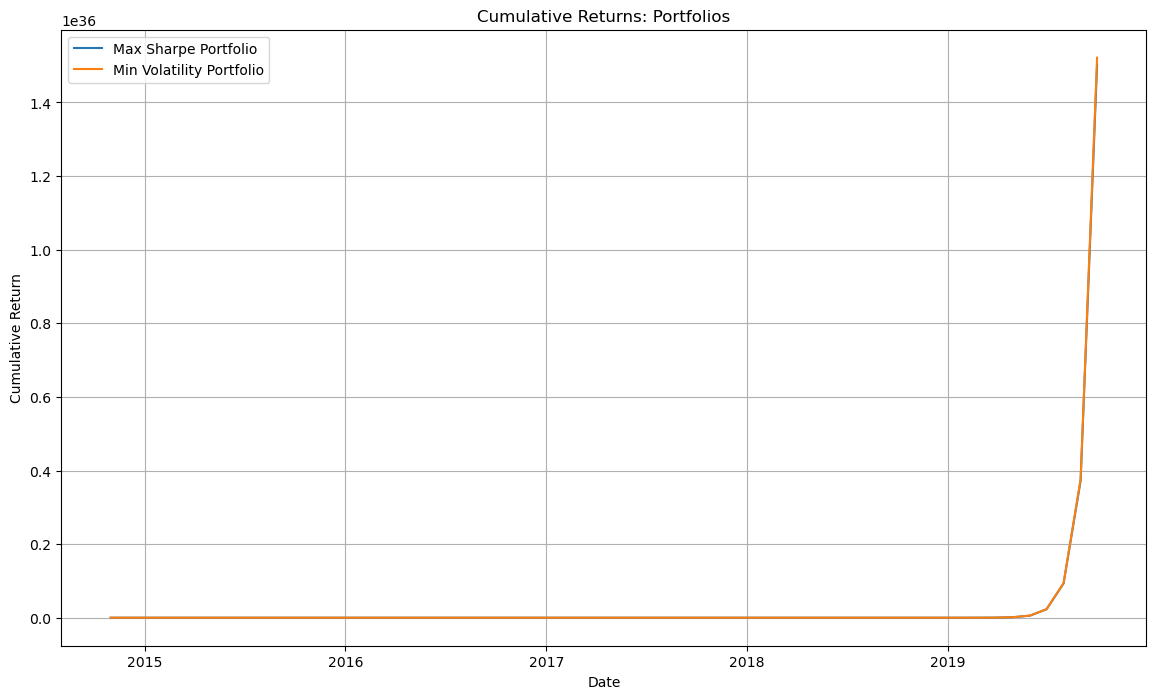

In [22]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe': {
        'BTC-USD': 0.0500,
        '^GSPC': 0.2462,
        'GLD': 0.3604,
        'TLT': 0.2657
    },
    'Min Volatility': {
        'BTC-USD': 0.0500,
        '^GSPC': 0.3350,
        'GLD': 0.3328,
        'TLT': 0.3434
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Initialize portfolio metrics storage
    portfolio_metrics = {}

    # Risk-free rate for Sharpe Ratio calculation
    risk_free_rate = 0.0382 / 12  # Assuming 1% annual risk-free rate, convert to monthly

    # Backtest each portfolio
    initial_investment = 100000

    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Calculate portfolio cumulative returns
        portfolio_cumulative_returns = (1 + portfolio_monthly_returns).cumprod() - 1
        
        # Calculate key performance metrics
        cumulative_return = portfolio_cumulative_returns.iloc[-1]
        annualized_return = (1 + cumulative_return) ** (12 / len(portfolio_monthly_returns)) - 1
        volatility = portfolio_monthly_returns.std() * np.sqrt(12)  # Annualize volatility
        sharpe_ratio = (annualized_return - risk_free_rate * 12) / volatility
        
        # Calculate Maximum Drawdown
        cumulative_returns_with_initial = (1 + portfolio_cumulative_returns)
        rolling_max = cumulative_returns_with_initial.cummax()
        drawdown = cumulative_returns_with_initial / rolling_max - 1
        max_drawdown = drawdown.min()
        
        # Store metrics
        portfolio_metrics[name] = {
            'Cumulative Return': cumulative_return,
            'Annualized Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Maximum Drawdown': max_drawdown
        }

    # Display performance metrics
    metrics_df = pd.DataFrame(portfolio_metrics).T

    print(metrics_df)

    # Plot the cumulative returns for each portfolio
    plt.figure(figsize=(14, 8))
    for name, metrics in portfolio_metrics.items():
        plt.plot((1 + monthly_returns * list(portfolios[name].values())).sum(axis=1).cumprod(), label=f'{name} Portfolio')
    plt.title('Cumulative Returns: Portfolios')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_7744\1878241550.py:62: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()


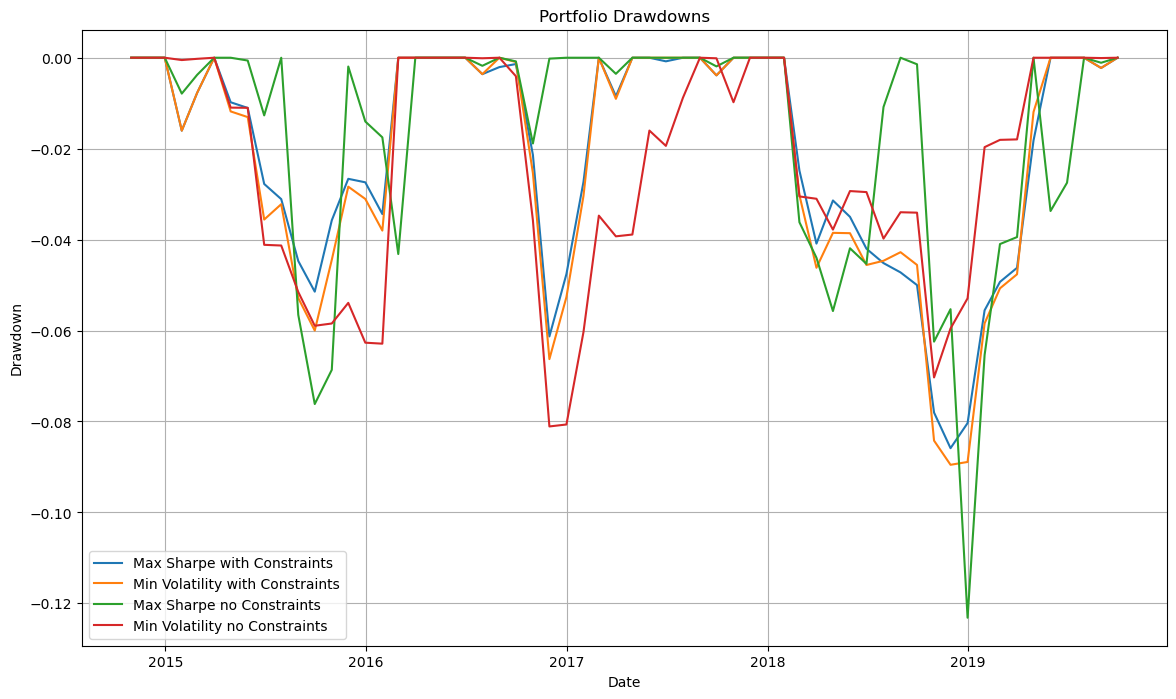

In [25]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe with Constraints': {
        'BTC-USD': 0.0500,
        '^GSPC': 0.2462,
        'GLD': 0.3604,
        'TLT': 0.2657
    },
    'Min Volatility with Constraints': {
        'BTC-USD': 0.0500,
        '^GSPC': 0.3350,
        'GLD': 0.3328,
        'TLT': 0.3434
    },
    'Max Sharpe no Constraints': {
        'BTC-USD': 0.0246,
        '^GSPC': 0.8409,
        'GLD': 0.0437,
        'TLT': 0.0909
    },
    'Min Volatility no Constraints': {
        'BTC-USD': 0.0016,
        '^GSPC': 0.3093,
        'GLD': 0.3304,
        'TLT': 0.3586
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Initialize a dictionary to store drawdown data
    drawdowns = {}

    # Backtest each portfolio
    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Calculate cumulative returns
        cumulative_returns = (1 + portfolio_monthly_returns).cumprod()

        # Calculate drawdown
        rolling_max = cumulative_returns.cummax()
        drawdown = (cumulative_returns - rolling_max) / rolling_max
        drawdowns[name] = drawdown

    # Convert drawdowns dictionary to DataFrame for easier plotting
    drawdown_df = pd.DataFrame(drawdowns)

    # Plot drawdowns
    plt.figure(figsize=(14, 8))
    for column in drawdown_df.columns:
        plt.plot(drawdown_df.index, drawdown_df[column], label=column)
    plt.title('Portfolio Drawdowns')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.grid(True)
    plt.show()


# Risk/Return Profile Scatter Plot

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_7744\2319358771.py:62: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()
C:\Users\Berke\AppData\Local\Temp\ipykernel_7744\2319358771.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (metrics_df['Volatility'][i], metrics_df

                                 Cumulative Return  Annualized Return  \
Max Sharpe with Constraints               0.613006           0.100341   
Min Volatility with Constraints           0.692518           0.110981   
Max Sharpe no Constraints                 0.659792           0.106651   
Min Volatility no Constraints             0.337081           0.059819   

                                 Volatility  Sharpe Ratio  
Max Sharpe with Constraints        0.078784      0.788750  
Min Volatility with Constraints    0.084515      0.861162  
Max Sharpe no Constraints          0.100582      0.680552  
Min Volatility no Constraints      0.072233      0.299291  


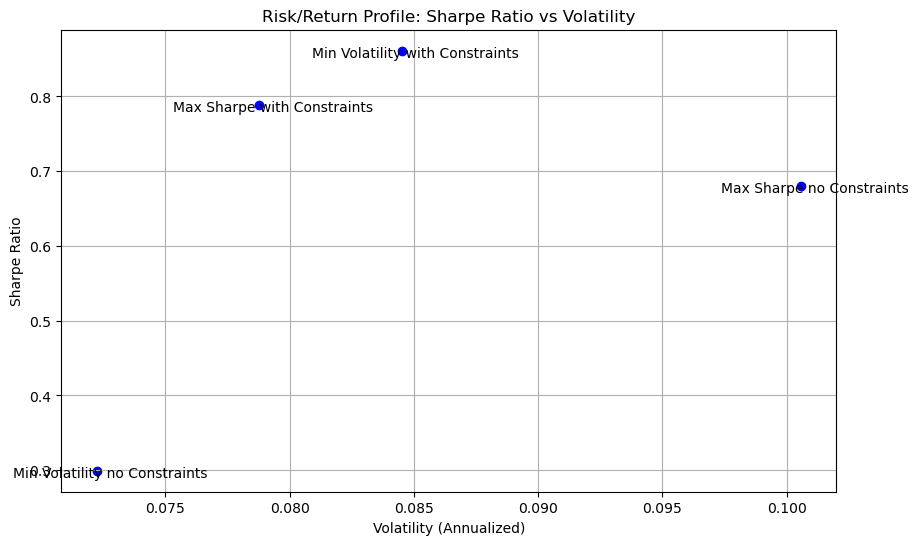

In [50]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe with Constraints': {
        'BTC-USD': 0.0500,
        '^GSPC': 0.2462,
        'GLD': 0.3604,
        'TLT': 0.2657
    },
    'Min Volatility with Constraints': {
        'BTC-USD': 0.0500,
        '^GSPC': 0.3350,
        'GLD': 0.3328,
        'TLT': 0.3434
    },
    'Max Sharpe no Constraints': {
        'BTC-USD': 0.0246,
        '^GSPC': 0.8409,
        'GLD': 0.0437,
        'TLT': 0.0909
    },
    'Min Volatility no Constraints': {
        'BTC-USD': 0.0016,
        '^GSPC': 0.3093,
        'GLD': 0.3304,
        'TLT': 0.3586
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Initialize portfolio metrics storage
    portfolio_metrics = {}

    # Risk-free rate for Sharpe Ratio calculation
    risk_free_rate = 0.0382 / 12  # Assuming 3.82% annual risk-free rate, convert to monthly

    # Backtest each portfolio
    initial_investment = 100000

    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Calculate portfolio cumulative returns
        portfolio_cumulative_returns = (1 + portfolio_monthly_returns).cumprod() - 1
        
        # Calculate key performance metrics
        cumulative_return = portfolio_cumulative_returns.iloc[-1]
        annualized_return = (1 + cumulative_return) ** (12 / len(portfolio_monthly_returns)) - 1
        volatility = portfolio_monthly_returns.std() * np.sqrt(12)  # Annualize volatility
        sharpe_ratio = (annualized_return - risk_free_rate * 12) / volatility
        
        # Store metrics
        portfolio_metrics[name] = {
            'Cumulative Return': cumulative_return,
            'Annualized Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio
        }

    # Display performance metrics
    metrics_df = pd.DataFrame(portfolio_metrics).T

    print(metrics_df)

    # Create a scatter plot for Sharpe Ratios vs Volatility
    plt.figure(figsize=(10, 6))
    plt.scatter(metrics_df['Volatility'], metrics_df['Sharpe Ratio'], color='blue')

    # Annotate the points
    for i in range(metrics_df.shape[0]):
        plt.annotate(metrics_df.index[i], 
                     (metrics_df['Volatility'][i], metrics_df['Sharpe Ratio'][i]), 
                     textcoords="offset points", 
                     xytext=(10,-5), 
                     ha='center')

    # Set plot labels and title
    plt.title('Risk/Return Profile: Sharpe Ratio vs Volatility')
    plt.xlabel('Volatility (Annualized)')
    plt.ylabel('Sharpe Ratio')
    plt.grid(True)
    plt.show()
